___
# Report classification using automatically extracted features
___

In [1]:
import numpy as np
import pandas as pd
import utils
from time import time
import pickle

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import *

# Display wide columns
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 100

___
## Data preparation

In [2]:
# Load the development set
df = pd.read_csv("../datasets/reports_dev.csv")

# Clean text
df['clean_text'] = df.report_text.apply(utils.clean_text)

# Extract concepts
df = utils.extract_features_cv(df)

# Define features and labels
feature_names = utils.get_feature_names("concepts") + utils.get_feature_names("composite")
X = utils.get_features(df, feature_names)
y = df.y
groups = df.patient_id

print("Using %d features." % X.shape[1])

Number of unique tokens in each category: [29, 56, 10, 13, 12, 43, 32, 5, 9]
Number of unique tokens in each category after expanding: [29, 56, 10, 15, 12, 43, 32, 5, 9]
Number of unique tokens in each category: [28, 57, 13, 17, 11, 38, 31, 4, 9]
Number of unique tokens in each category after expanding: [28, 57, 13, 17, 11, 38, 31, 4, 9]
Number of unique tokens in each category: [31, 60, 14, 15, 13, 44, 33, 5, 9]
Number of unique tokens in each category after expanding: [31, 60, 14, 15, 13, 44, 33, 5, 9]
Number of unique tokens in each category: [26, 58, 14, 13, 13, 41, 30, 5, 9]
Number of unique tokens in each category after expanding: [26, 58, 14, 14, 13, 41, 30, 5, 9]
Number of unique tokens in each category: [30, 58, 14, 16, 13, 42, 33, 5, 8]
Number of unique tokens in each category after expanding: [30, 58, 14, 17, 13, 42, 33, 5, 8]
Number of unique tokens in each category: [30, 53, 14, 14, 12, 40, 32, 5, 7]
Number of unique tokens in each category after expanding: [30, 53, 14, 16

___
## Model selection
### Quick&dirty trying a few algorithms

In [3]:
clfs = (
    LogisticRegression(solver='saga', penalty='l1', 
                       max_iter=5000, class_weight='balanced', random_state=42),
    LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5, 
                       max_iter=5000, class_weight='balanced', random_state=42),
    LogisticRegression(solver='saga', 
                       max_iter=5000, class_weight='balanced', random_state=42),
)

for clf in clfs:
    utils.score_cv(clf, X, y, groups)

________________________________________________________________________________
Training with 10-fold cross-validation:
LogisticRegression(class_weight='balanced', max_iter=5000, penalty='l1',
                   random_state=42, solver='saga')
train time: 1.165s
ROC AUC score: 0.990 (+/- 0.02)
AP score: 0.981 (+/- 0.04)

________________________________________________________________________________
Training with 10-fold cross-validation:
LogisticRegression(class_weight='balanced', l1_ratio=0.5, max_iter=5000,
                   penalty='elasticnet', random_state=42, solver='saga')
train time: 0.125s
ROC AUC score: 0.994 (+/- 0.02)
AP score: 0.986 (+/- 0.04)

________________________________________________________________________________
Training with 10-fold cross-validation:
LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42,
                   solver='saga')
train time: 0.106s
ROC AUC score: 0.998 (+/- 0.00)
AP score: 0.993 (+/- 0.02)



### Tune the final model

In [4]:
clf = LogisticRegression(solver='saga', penalty='elasticnet', 
                         max_iter=5000, class_weight='balanced', random_state=42)

c = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.5, 1, 10, 15, 20, 25, 30, 50]
l1_ratio = [1.0, 0.75, 0.5, 0.25, 0.0]
param_grid = {
    'C': c, 
    'l1_ratio': l1_ratio,
}

best_params = utils.search_params(clf, 'grid', param_grid, X, y, groups)
best_model = clf.set_params(**best_params)

Best for current fold: 1.000 using {'C': 0.1, 'l1_ratio': 0.0}
0.133 (+/- 0.070) with: {'C': 1e-05, 'l1_ratio': 1.0}
0.133 (+/- 0.070) with: {'C': 1e-05, 'l1_ratio': 0.75}
0.133 (+/- 0.070) with: {'C': 1e-05, 'l1_ratio': 0.5}
0.133 (+/- 0.070) with: {'C': 1e-05, 'l1_ratio': 0.25}
0.849 (+/- 0.220) with: {'C': 1e-05, 'l1_ratio': 0.0}
0.133 (+/- 0.070) with: {'C': 0.0001, 'l1_ratio': 1.0}
0.133 (+/- 0.070) with: {'C': 0.0001, 'l1_ratio': 0.75}
0.133 (+/- 0.070) with: {'C': 0.0001, 'l1_ratio': 0.5}
0.133 (+/- 0.070) with: {'C': 0.0001, 'l1_ratio': 0.25}
0.907 (+/- 0.172) with: {'C': 0.0001, 'l1_ratio': 0.0}
0.133 (+/- 0.070) with: {'C': 0.001, 'l1_ratio': 1.0}
0.133 (+/- 0.070) with: {'C': 0.001, 'l1_ratio': 0.75}
0.133 (+/- 0.070) with: {'C': 0.001, 'l1_ratio': 0.5}
0.133 (+/- 0.070) with: {'C': 0.001, 'l1_ratio': 0.25}
0.964 (+/- 0.055) with: {'C': 0.001, 'l1_ratio': 0.0}
0.828 (+/- 0.164) with: {'C': 0.01, 'l1_ratio': 1.0}
0.851 (+/- 0.170) with: {'C': 0.01, 'l1_ratio': 0.75}
0.910 (+/

In [5]:
best_model =  LogisticRegression(solver='saga', penalty='elasticnet', 
                                 max_iter=5000, class_weight='balanced', random_state=42, 
                                 C=0.25, l1_ratio=0.25)

___
## Model evaluation
### Evaluate the final model using CV

In [6]:
# Model performance in each CV fold
utils.score_cv(best_model, X, y, groups)

# Make predictions for each CV fold
y_proba = utils.predict_cv(best_model, X, y, groups, options=[])

________________________________________________________________________________
Training with 10-fold cross-validation:
LogisticRegression(C=0.25, class_weight='balanced', l1_ratio=0.25,
                   max_iter=5000, penalty='elasticnet', random_state=42,
                   solver='saga')
train time: 0.138s
ROC AUC score: 1.000 (+/- 0.00)
AP score: 1.000 (+/- 0.00)



The threshold optimises F1-score calculated from the PR curve.
Best threshold for the model = 0.621, F1-score = 0.906

Proportion of labels predicted as positive: 13.9%
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       198
           1       0.91      0.91      0.91        32

    accuracy                           0.97       230
   macro avg       0.95      0.95      0.95       230
weighted avg       0.97      0.97      0.97       230

PPV: 0.91, Sensitivity: 0.91, Specificity: 0.98


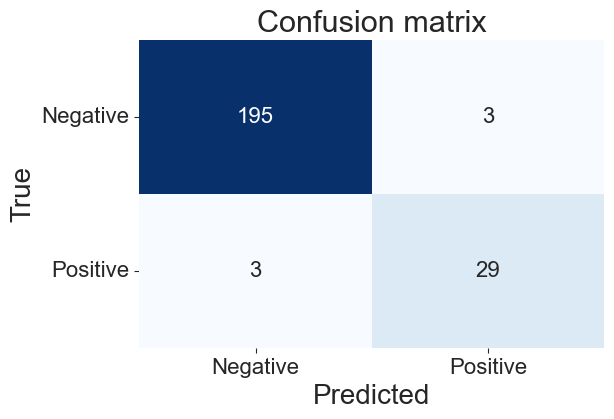

In [7]:
# Find the optimal threshold using aggregated predictions
thresh = utils.select_threshold(y, y_proba)

# Evaluate classification using aggregated predictions
utils.evaluate_classification(y, y_proba, thresh, filename="auto_cv")

### Train the final model on the full development set

In [8]:
# Learn vocabulary from the training set
vocab = utils.create_vocab(df.report_id, expand=True)

# Extract concepts from the training set
df = utils.extract_features(df, vocab)

Number of unique tokens in each category: [32, 61, 14, 17, 13, 44, 33, 5, 9]
Number of unique tokens in each category after expanding: [32, 61, 14, 17, 13, 44, 33, 5, 9]


In [9]:
# Re-train the final model on the full training set
X = utils.get_features(df, feature_names)

# Fit the model
best_model.fit(X, y)

LogisticRegression(C=0.25, class_weight='balanced', l1_ratio=0.25,
                   max_iter=5000, penalty='elasticnet', random_state=42,
                   solver='saga')

### Examine model coefficients

In [10]:
intercept = best_model.intercept_
coefs = best_model.coef_[0]
null_coef = (coefs == 0).sum()
print("The intercept = %.2f." % intercept)
print("%d coefficients are set to 0.0, %d features remaining:" % (null_coef, len(feature_names) - null_coef))
for ft, w in zip(feature_names, coefs):
    print('{0:30}  {1}'.format(ft, w.round(2)))

The intercept = -1.10.
4 coefficients are set to 0.0, 13 features remaining:
ClinicalQuery                   0.0
FungalDescriptor                0.95
Fungus                          1.05
Invasiveness                    0.15
Stain                           0.0
SampleType                      -0.21
positive                        0.03
equivocal                       -0.13
negative                        -0.59
affirmedFungalDescriptor        0.85
affirmedFungus                  0.71
affirmedInvasiveness            0.0
affirmedStain                   0.32
negatedFungalDescriptor         -0.46
negatedFungus                   -0.21
negatedInvasiveness             0.0
negatedStain                    -0.57


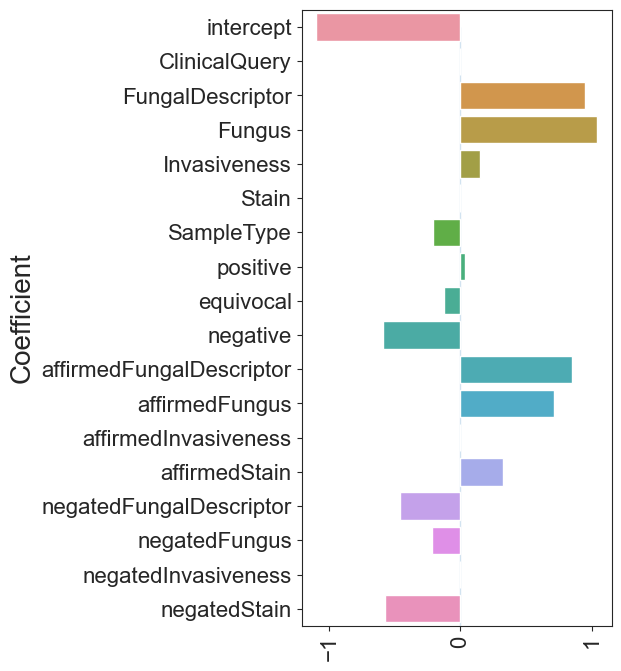

In [11]:
utils.plot_coefficients(intercept, coefs, feature_names, filename="auto")

### Test the final model on test data

In [12]:
# Load the test set
df_test = pd.read_csv("../datasets/reports_test.csv")

# Clean text
df_test['clean_text'] = df_test.report_text.apply(utils.clean_text)

# Extract concepts from the test set
df_test = utils.extract_features(df_test, vocab)

# Define test set features and labels
X_test = utils.get_features(df_test, feature_names)
y_test = df_test.y

# Make predictions
y_proba = best_model.predict_proba(X_test)
y_proba = y_proba[:,1]

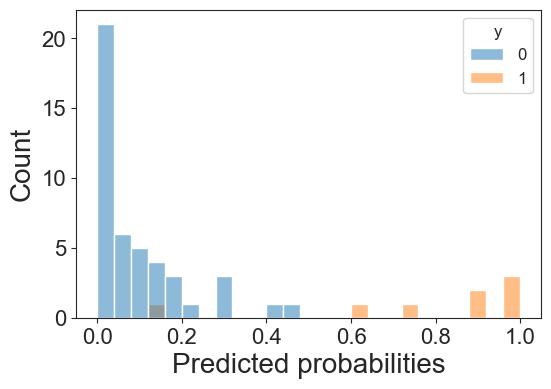

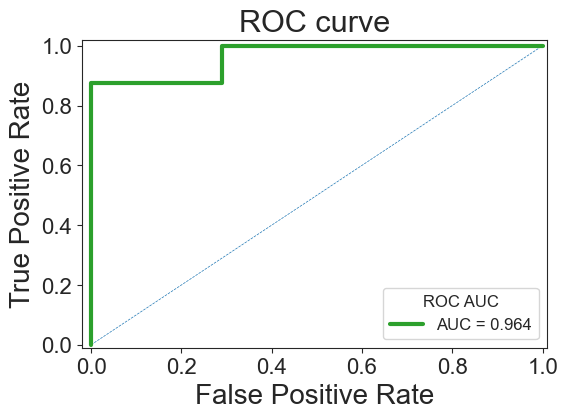

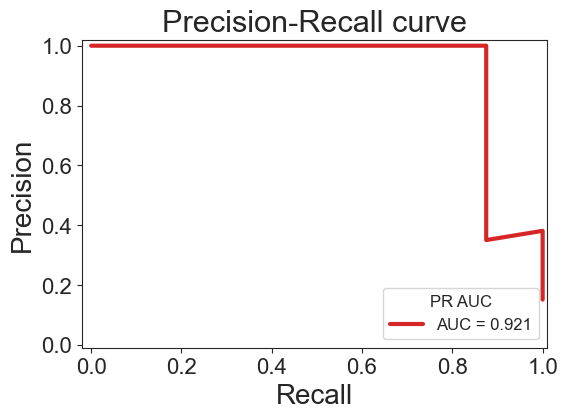

In [13]:
# Plot curves
utils.plot_curves(y_test, y_proba, filename="auto_test")

Proportion of labels predicted as positive: 13.2%
Classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        45
           1       1.00      0.88      0.93         8

    accuracy                           0.98        53
   macro avg       0.99      0.94      0.96        53
weighted avg       0.98      0.98      0.98        53

PPV: 1.00, Sensitivity: 0.88, Specificity: 1.00


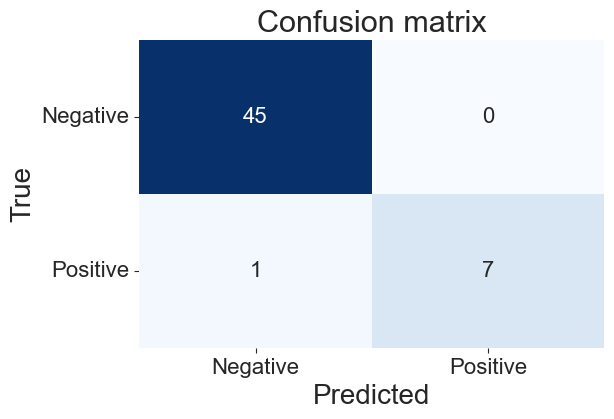

In [14]:
# Evaluate classification
_ = utils.evaluate_classification(y_test, y_proba, thresh, filename="auto_test")

### Save the final model, the vocabulary and the threshold value

In [15]:
with open("../models/classifier_train.sav", 'wb') as f:
    pickle.dump(best_model, f)
with open("../models/vocab_train.sav", 'wb') as f:
    pickle.dump(vocab, f)   
with open("../models/thresh_train.txt", 'w') as f:
    f.write(str(thresh))  